### Libraries

In [1]:
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from IPython.display import Image

import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from yellowbrick.model_selection import FeatureImportances

from imblearn.over_sampling import SMOTE, ADASYN

import xgboost as xgb
from plot_learning import *
from sklearn.svm import SVC
from sklearn_rvm import EMRVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

warnings.filterwarnings('ignore')

c:\Anaconda\envs\artigo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read 

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

X_train = pd.read_csv("X_train.csv", sep = ";")
X_test = pd.read_csv("X_test.csv", sep = ";")

y_train = pd.read_csv("y_train.csv", sep = ";")
y_test = pd.read_csv("y_test.csv", sep = ";")

X_train.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO
0,63,34,27,10.3,8.3,48.7,11.5,1.19,0.46,0.52
1,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40
2,66,34,29,11.4,5.8,49.4,11.1,0.87,0.25,0.23
3,101,77,46,10.9,13.3,52.2,17.3,1.48,0.27,1.07
4,83,46,19,8.5,10.3,49.3,14.9,1.05,0.39,0.39


In [3]:
## removendo variáveis 
X_train = X_train.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

X_test = X_test.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

In [4]:
X_train.columns

Index(['RFV', 'H2RFV', 'CONICITY', 'PLY', 'LFV', 'RRO', 'CAPSPLICE'], dtype='object')

In [5]:
y_train.GR.unique()

array(['B', 'A', 'C'], dtype=object)

In [6]:
y_train.GR.value_counts()

B    35
A    34
C    11
Name: GR, dtype: int64

## Dataprep

In [7]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

In [8]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [9]:
print(Counter(y_train_enc).keys())
print(Counter(y_train_enc).values())

dict_keys([1, 0, 2])
dict_values([35, 34, 11])


In [10]:
print(Counter(y_test_enc).keys())
print(Counter(y_test_enc).values())

dict_keys([1, 0, 2])
dict_values([11, 12, 4])


In [11]:
file_minmax = "./models/minmax.pickle"
file_smote = "./models/smote.pickle"

minmax = joblib.load(file_minmax)
smote= joblib.load(file_smote)

In [12]:
X_train_minmax = minmax.transform(X_train)
X_test = minmax.transform(X_test)

In [13]:
X_resampled, y_resampled = smote.fit_resample(X_train_minmax, y_train_enc)

In [14]:
print(Counter(y_resampled).keys())
print(Counter(y_resampled).values())

dict_keys([1, 0, 2])
dict_values([35, 35, 35])


## Predict

In [15]:
def fit_and_print(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # print("Confusion Matrix: \n", confusion_matrix(y_test_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred))  

### Models

In [17]:
filename_1 = './models/RF_best_bayes_resampled.sav'
filename_2 = './models/SVM_best_bayes_resampled.sav'
filename_3 = './models/LR_best_bayes_resampled.sav'
filename_4 = './models/MLP_best_resampled.sav'
filename_5 = './models/KNN_best_bayes_resampled.sav'
filename_6 = './models/GP_best_bayes_resampled.sav'
filename_7 = './models/GBM_best_bayes_resampled.sav'
filename_8 = './models/LGBM_best_bayes_resampled.sav'
filename_9 = './models/XGB_best_bayes_resampled.sav'


RF_best = joblib.load(filename_1)
SVM_best = joblib.load(filename_2)
LR_best = joblib.load(filename_3)
MLP_best = joblib.load(filename_4)
KNN_best = joblib.load(filename_5)
GP_best = joblib.load(filename_6)
GBM_best = joblib.load(filename_7)
LGBM_best = joblib.load(filename_8)
# XGB_best = joblib.load(filename_9)

### Voting Classifier

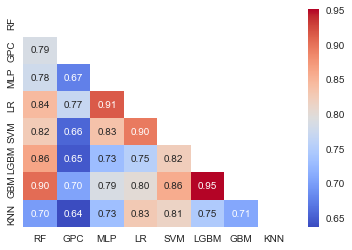

In [24]:
model_RF = pd.Series(RF_best.predict(X_test), name="RF")
model_GP = pd.Series(GP_best.predict(X_test), name="GPC")
model_MLP = pd.Series(MLP_best.predict(X_test), name="MLP")
model_LR = pd.Series(LR_best.predict(X_test), name= "LR")
model_SVM = pd.Series(SVM_best.predict(X_test), name="SVM")
model_GBM = pd.Series(GBM_best.predict(X_test), name="GBM")
model_LGBM = pd.Series(LGBM_best.predict(X_test), name="LGBM")
# model_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")
model_KNN = pd.Series(KNN_best.predict(X_test), name="KNN")

# Concatenate all classifier results
m= pd.concat([model_RF, model_GP, model_MLP, model_LR, model_SVM, model_LGBM, model_GBM, model_KNN],axis=1)

corrmat = np.triu(m.corr(method='kendall'))

g= sns.heatmap(m.corr(method='kendall'),cmap="coolwarm",annot=True, fmt=".2f", mask = corrmat)

In [25]:
import scipy.stats as stats

tau, p_value = stats.kendalltau(model_RF, model_GP)
p_value

1.0466834713430238e-05

In [28]:
def fit_and_print_v2(model, X_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_enc, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test_enc, y_pred))  


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.90      0.82      0.86        11
           2       0.60      0.75      0.67         4

    accuracy                           0.89        27
   macro avg       0.83      0.86      0.84        27
weighted avg       0.90      0.89      0.89        27



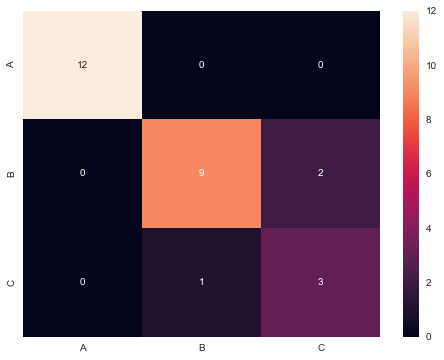

In [29]:
fit_and_print_v2(RF_best, X_test)

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       0.83      0.45      0.59        11
           2       0.60      0.75      0.67         4

    accuracy                           0.74        27
   macro avg       0.73      0.73      0.70        27
weighted avg       0.76      0.74      0.72        27



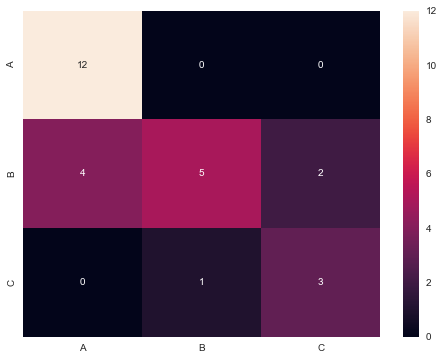

In [30]:
fit_and_print_v2(GP_best, X_test)